## Fine-tuning a model based on our dataset

Our goal is to create a model that can take a piece of text as input, determine the emotion of the text, and return this emotion label for us.

To do this, we'll be fine-tuning an XLNet model. We have a labeled dataset of a number of different sentences and their emotion labels. We'll provide this to the model so that it can learn these associations from our data. We'll then have a custom fine-tuned language model of our own. 

In [65]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 
import evaluate
import random

## Preprocess our data

In [66]:
data_train = pd.read_csv('./emotions_data/emotion-labels-train.csv') 
data_test = pd.read_csv('./emotions_data/emotion-labels-test.csv')
data_val = pd.read_csv('./emotions_data/emotion-labels-val.csv')

In [67]:
data_train.head(15)

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
5,"Today I reached 1000 subscribers on YT!! , #go...",joy
6,"@Singaholic121 Good morning, love! Happy first...",joy
7,#BridgetJonesBaby is the best thing I've seen ...,joy
8,Just got back from seeing @GaryDelaney in Burs...,joy
9,@IndyMN I thought the holidays could not get a...,joy


In [68]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)
data.head(15)

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
5,"Today I reached 1000 subscribers on YT!! , #go...",joy
6,"@Singaholic121 Good morning, love! Happy first...",joy
7,#BridgetJonesBaby is the best thing I've seen ...,joy
8,Just got back from seeing @GaryDelaney in Burs...,joy
9,@IndyMN I thought the holidays could not get a...,joy


In [69]:
# Remove 
# data["text_clean"] = data["text"].apply(lambda x: clean(x, punct=True))

# Remove punctuations and emojis
data["text_clean"] = data["text"].apply(lambda x: re.sub(r"[^\w\s]", "", x))

data.head(15)


,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing GaryDelaney in Bursl...
1,Oh dear an evening of absolute hilarity I don'...,joy,Oh dear an evening of absolute hilarity I dont...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,Been waiting all week for this game cheer fri...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,gardiner_love Thank you so much Gloria Youre ...
4,I feel so blessed to work with the family that...,joy,I feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,Today I reached 1000 subscribers on YT goodda...
6,"@Singaholic121 Good morning, love! Happy first...",joy,Singaholic121 Good morning love Happy first da...
7,#BridgetJonesBaby is the best thing I've seen ...,joy,BridgetJonesBaby is the best thing Ive seen in...
8,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing GaryDelaney in Bursl...
9,@IndyMN I thought the holidays could not get a...,joy,IndyMN I thought the holidays could not get an...


<Axes: xlabel='label'>

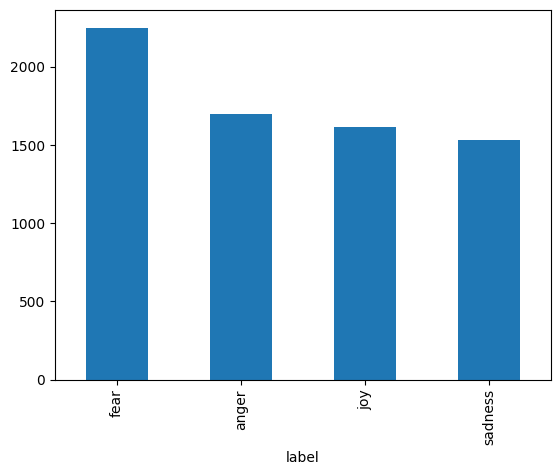

In [70]:
data["label"].value_counts().plot(kind="bar")

We can also see this is an unbalanced dataset. We have a lot more occurrences of text with the label fear compared to sadness, so we want to make sure we have an equal number of pieces of text for each of our labels.

The first thing we can do is take our data and group it by the label. We then want to create a new dataframe. From this, we're going to sample based on the size of the number of rows in the labels. We'll take the minimum and then reset the index with drop=True.

In [71]:
"""
Essentially, what this is doing is taking our dataframe, grouping it by the label, 
finding the group with the least number of rows—in this case, sadness—and then using 
that minimum value to sample from all the other labels.
"""

g = data.groupby("label")
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

/var/folders/jr/f0qqbf7x1jz_k7v8_55tf3ph0000gn/T/ipykernel_82688/2369473014.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

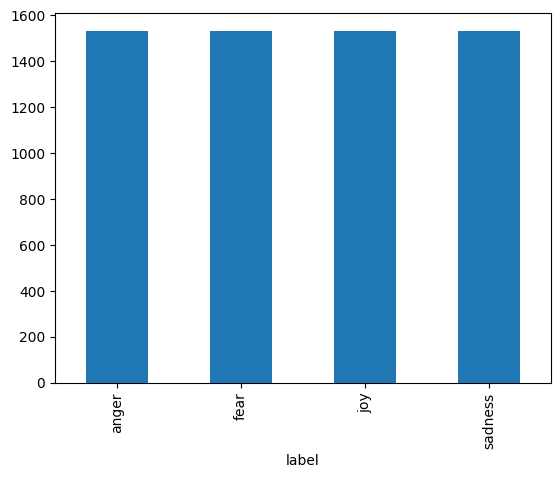

In [72]:
data["label"].value_counts().plot(kind="bar")

In [73]:
data["label_int"] = LabelEncoder().fit_transform(data["label"])
data.head()

text  label  \
label                                                               
anger 0  when you find out the initiative isn't even a ...  anger   
      1  Follow up. Follow through. Be #relentless. #su...  anger   
      2  @billburr DirectTV is the best. Apparently you...  anger   
      3  @kingcharles9th i Lowkey forgot you had twitte...  anger   
      4  Asian Tiger #Mosquitoes are so relentless. Mor...  anger   

                                                text_clean  label_int  
label                                                                  
anger 0  when you find out the initiative isnt even a t...          0  
      1     Follow up Follow through Be relentless success          0  
      2  billburr DirectTV is the best Apparently you j...          0  
      3  kingcharles9th i Lowkey forgot you had twitter...          0  
      4  Asian Tiger Mosquitoes are so relentless More ...          0

In [74]:
NUM_LABELS = 4

## Create our training and test data

In [75]:
train_split, test_split = train_test_split(data, train_size=0.8)

# We need a validation set, so let's further split our training set
train_split, val_split = train_test_split(train_split, train_size=0.9)

print("Training set: ", len(train_split))
print("Validation set: ", len(val_split))
print("Test set: ", len(test_split))
print("Total set: ", len(data))


Training set:  4414
Validation set:  491
Test set:  1227
Total set:  6132


In [76]:
# Let's format our data into a data set dictionary and remove any columns we will not be using

train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})

val_df = pd.DataFrame({
    "label": val_split.label_int.values,
    "text": val_split.text_clean.values
})

test_df = pd.DataFrame({
    "label": test_split.label_int.values,
    "text": test_split.text_clean.values
})

train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

dataset_dict = datasets.DatasetDict({"traiin": train_df, "test": test_df})
dataset_dict

DatasetDict({
    traiin: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

## Create embeddings

In [78]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

ImportError: 
XLNetTokenizer requires the SentencePiece library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


## Fine-tuning our model